In [15]:
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, GlobalAveragePooling1D,Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from keras.utils import plot_model




In [16]:
# 2. Đọc file csv và gắng index với giá Close
# Chuẩn bị dữ liệu
data = pd.read_csv('../../Dataset/VCB-Historical-Data_Group-9.csv', index_col='Date', parse_dates=True)

In [17]:
# 3. Chuyển các giá trị trong cột về number
# Hàm chuyển đổi
def convert_str_to_number(str):
    return float(str.replace(',', ''))

def convert_change_to_number(change_str):
    return float(change_str.strip('%')) / 100

def convert_volume_to_number(volume_str):
    factor = {'K': 1000, 'M': 1000000, 'B': 1000000000}
    return int(float(volume_str[:-1]) * factor[volume_str[-1]]) if volume_str[-1] in factor else int(volume_str)

# Áp dụng hàm chuyển đổi cho các cột giá trị
data['Price'], data['Open'], data['High'], data['Low'] = [data[col].apply(convert_str_to_number) for col in ['Price', 'Open', 'High', 'Low']]
data['Change %'] = data['Change %'].apply(convert_change_to_number)
data["Vol."] = data["Vol."].apply(convert_volume_to_number)

data.reset_index(drop=True, inplace=True)
data.head(10)

,Price,Open,High,Low,Vol.,Change %
0,47765.0,46844.0,47765.0,46690.0,910430,0.0281
1,48226.0,47765.0,48379.0,47765.0,1720000,0.0097
2,48379.0,48226.0,48994.0,47995.0,2009999,0.0032
3,48149.0,48456.0,48610.0,47535.0,1380000,-0.0048
4,48456.0,48149.0,48994.0,48072.0,2420000,0.0064
5,48226.0,47919.0,48379.0,47688.0,1270000,-0.0047
6,48072.0,47919.0,48149.0,47535.0,1300000,-0.0032
7,49762.0,48379.0,49762.0,48149.0,2800000,0.0352
8,50069.0,49915.0,50069.0,49531.0,2140000,0.0062
9,51451.0,50069.0,51451.0,49531.0,2900000,0.0276


In [18]:

# 4. Scaler data

# Sử dụng MinMaxScaler để chuẩn hóa dữ liệu
price = data['Price'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)


In [19]:
# 5. Chia train test
# Chia dữ liệu thành train và test
train_size = int(len(price_scaled) * 0.8)
test_size = len(price_scaled) - train_size
train_data = price_scaled[:train_size]
test_data = price_scaled[train_size:]

# Hàm để tạo dataset
def create_dataset(dataset, time_series=1):
    X, Y = [], []
    for i in range(len(dataset) - time_series):
        X.append(dataset[i:i + time_series, 0])
        Y.append(dataset[i + time_series, 0])
    return np.array(X), np.array(Y)

# Sử dụng time_series để tạo tập huấn luyện và tập kiểm tra
time_series = 30
X_train, Y_train = create_dataset(train_data, time_series)
X_test, Y_test = create_dataset(test_data, time_series)

# Định hình lại X_train và X_test cho mô hình 
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Kiểm tra hình dạng của dữ liệu
print(f'X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}')
print(f'X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}')

X_train shape: (1020, 30, 1), Y_train shape: (1020,)
X_test shape: (233, 30, 1), Y_test shape: (233,)


In [20]:
#6. Xây dựng mô hình và train mô hình
model = Sequential()

# Add convolutional layers

model.add(Conv1D(filters=256, kernel_size=3, activation='relu', input_shape=(time_series, 1)))
model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Conv1D(filters=1, kernel_size=3, activation='relu'))

# Add global average pooling layer
model.add(GlobalAveragePooling1D())

# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

# Huấn luyện mô hình
model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=(X_test, Y_test))



Epoch 1/100
16/16 [==============================] - 1s 30ms/step - loss: 0.0739 - val_loss: 0.0670
Epoch 2/100
16/16 [==============================] - 0s 21ms/step - loss: 0.0139 - val_loss: 0.0034
Epoch 3/100
16/16 [==============================] - 0s 20ms/step - loss: 0.0073 - val_loss: 0.0051
Epoch 4/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0065 - val_loss: 0.0085
Epoch 5/100
16/16 [==============================] - 0s 19ms/step - loss: 0.0063 - val_loss: 0.0054
Epoch 6/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0061 - val_loss: 0.0042
Epoch 7/100
16/16 [==============================] - 0s 17ms/step - loss: 0.0060 - val_loss: 0.0066
Epoch 8/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0059 - val_loss: 0.0050
Epoch 9/100
16/16 [==============================] - 0s 18ms/step - loss: 0.0059 - val_loss: 0.0043
Epoch 10/100
16/16 [==============================] - 0s 21ms/step - loss: 0.0059 - val_loss: 0.0055

In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 28, 256)           1024      
                                                                 
 conv1d_6 (Conv1D)           (None, 26, 128)           98432     
                                                                 
 conv1d_7 (Conv1D)           (None, 24, 64)            24640     
                                                                 
 conv1d_8 (Conv1D)           (None, 22, 32)            6176      
                                                                 
 conv1d_9 (Conv1D)           (None, 20, 1)             97        
                                                                 
 global_average_pooling1d_1  (None, 1)                 0         
  (GlobalAveragePooling1D)                                       
                                                      

In [22]:
# 7. Dự báo trên tập test
test_predict = model.predict(X_test)

test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([Y_test])

8/8 [==============================] - 1s 9ms/step


In [23]:
# 8. Dự báo giá trị 30 ngày trong tương lai
last_30_days = price_scaled[-30:]
next_30_days = []
for i in range(30):
    x = last_30_days[-time_series:].reshape(1, time_series, 1)
    y_hat = model.predict(x)
    next_30_days.append(y_hat)
    last_30_days = np.append(last_30_days, y_hat, axis=0)

next_30_days = np.array(next_30_days).reshape(-1, 1)
next_30_days = scaler.inverse_transform(next_30_days)

# print(next_30_days)



1/1 [==============================] - 0s 108ms/step


In [24]:
# 9. Dự báo giá trị 60 ngày trong tương lai
last_60_days = price_scaled[-60:]
next_60_days = []
for i in range(60):
    x = last_60_days[-time_series:].reshape(1, time_series, 1)
    y_hat = model.predict(x)
    next_60_days.append(y_hat)
    last_60_days = np.append(last_60_days, y_hat, axis=0)

next_60_days = np.array(next_60_days).reshape(-1, 1)
next_60_days = scaler.inverse_transform(next_60_days)

# print(next_60_days)


1/1 [==============================] - 0s 35ms/step


In [25]:
# 14. Dự báo 90 ngày tiếp theo

last_90_days = price_scaled[-90:]
next_90_days = []
for i in range(90):
    x = last_90_days[-time_series:].reshape(1, time_series, 1)
    y_hat = model.predict(x)
    next_90_days.append(y_hat)
    last_90_days = np.append(last_90_days, y_hat, axis=0)

next_90_days = np.array(next_90_days).reshape(-1, 1)
next_90_days = scaler.inverse_transform(next_90_days)

# print(next_90_days)

1/1 [==============================] - 0s 100ms/step


In [26]:
test_predict_df = pd.DataFrame(test_predict)
test_predict_index = range(len(train_data)+time_series, len(train_data)+time_series+len(test_predict))
test_predict_df.index = test_predict_index

next_30_days_df = pd.DataFrame(next_30_days)
next_30_index = range(len(data), len(data)+len(next_30_days))
next_30_days_df.index = next_30_index

next_60_days_df = pd.DataFrame(next_60_days)
next_60_index = range(len(data), len(data)+len(next_60_days))
next_60_days_df.index = next_60_index

next_90_days_df = pd.DataFrame(next_90_days)
next_90_index = range(len(data), len(data)+len(next_90_days))
next_90_days_df.index = next_90_index

train_data_df = data[:train_size][['Price']]
test_data_df = data[train_size:train_size + test_size][['Price']]

# y_pred_=scaler.inverse_transform(test_predict)

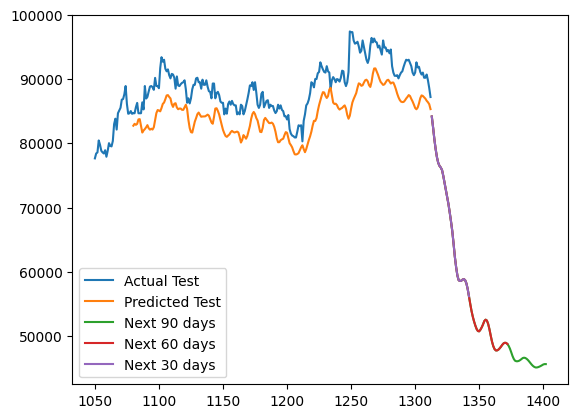

In [27]:
#11. Vẽ đồ thị các giá trị từ train tới test và dự đoán 90 ngày sau
# plt.plot(train_data_df, label='Train')
plt.plot(test_data_df, label='Actual Test')
plt.plot(test_predict_df, label='Predicted Test')
plt.plot(next_90_days_df, label='Next 90 days')
plt.plot(next_60_days_df, label='Next 60 days')
plt.plot(next_30_days_df, label='Next 30 days')
plt.legend()
plt.show()



In [28]:
#12. Đánh giá mô hình
test_score_rmse = np.sqrt(mean_squared_error(Y_test[0], test_predict[:, 0]))
test_score_mae = mean_absolute_error(Y_test[0], test_predict[:, 0])
test_score_mape = mean_absolute_percentage_error(Y_test[0], test_predict[:, 0])

print('RMSE :', test_score_rmse)
print('MAE :', test_score_mae)
print('MAPE :', test_score_mape*100)

RMSE : 4811.837679835287
MAE : 4469.936393508584
MAPE : 4.980779191088057
